In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

#from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

#import mitequinox.plot as pl
#import mitequinox.sigp as sp

In [2]:
# Load data
region = 'polynesia'
root_dir = '/Users/zcaspar/codes/mit4320/'

df = pd.read_parquet(root_dir+'Lagrangian_data_'+region) # Lagrangian data

ds = xr.open_dataset(root_dir+'Eulerian_data_'+region+'.nc') # Eulerian data

In [78]:
time = np.unique(df.index)
df = df.loc[time[::3]]

dfi = df.loc['2011-11':'2012-09']

In [79]:
ds

<xarray.Dataset>
Dimensions:                   (time: 2568, lon: 24, lat: 26)
Coordinates:
  * lon                       (lon) float64 -106.0 -105.9 ... -104.2 -104.1
  * lat                       (lat) float64 9.969 9.894 9.818 ... 8.146 8.07
    face                      int64 ...
    i                         (lat) int64 ...
    j                         (lon) int64 ...
  * time                      (time) datetime64[ns] 2011-11-15 ... 2012-09-30...
Data variables:
    SSU_rot                   (time, lon, lat) float32 ...
    XC                        (lon, lat) float32 ...
    YC                        (lon, lat) float32 ...
    Depth                     (lon, lat) float32 ...
    SSU_rot_hat_low           (lon, lat, time) float64 ...
    SSU_rot_demodulated_real  (lon, lat, time) float64 ...
    SSU_rot_demodulated_imag  (lon, lat, time) float64 ...
    SSU_rot_hat_real          (lon, lat, time) float64 ...
    SSU_rot_hat_imag          (lon, lat, time) float64 ...

In [80]:
ds['SSU_rot_demodulated'] = ds['SSU_rot_demodulated_real'] + 1j*ds['SSU_rot_demodulated_imag']

In [19]:
v='SSU_rot'
area = region+'/'
def gen_figs(it,savefig=False):
    name=v+'_%s'%it
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    cs_low = dsi[v+'_hat_low'].isel(time=it).plot.contourf(ax=ax[1],x='lon',y='lat',vmax=0.4,vmin=-0.4,cmap='RdBu_r',
                                                          cbar_kwargs={'label':'Low pass filtered'},levels=50)
    cs_hf = np.abs(dsi[v+'_demodulated']).isel(time=it).plot.contourf(ax=ax[2],x='lon',y='lat',vmax=0.3,vmin=0,cmap='Reds',
                                                        cbar_kwargs={'label':'Instantaneous tidal amplitude'},levels=50)
    cs = dsi[v].isel(time=it).plot.contourf(ax=ax[0],x='lon',y='lat',vmax=0.4,vmin=-0.4,cmap='RdBu_r',
                                           cbar_kwargs={'label':'Raw signal'},levels=50)
    for a in ax:
        a.set_title('Time : %s'%dsi[v].isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/Users/zcaspar/Videos/Figures_'+area+'u_raw/'+name+'.jpg')
        plt.close()
#    return cs,cs_low,cs_hf

In [92]:
dsi = ds.isel(time=slice(0,None,2))

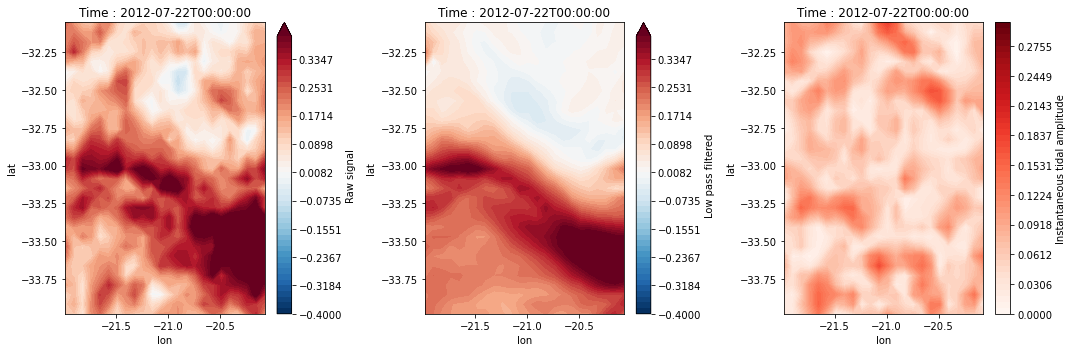

In [21]:
gen_figs(1000)

In [23]:
for i in range(dsi.time.size):
    gen_figs(i,savefig=True)

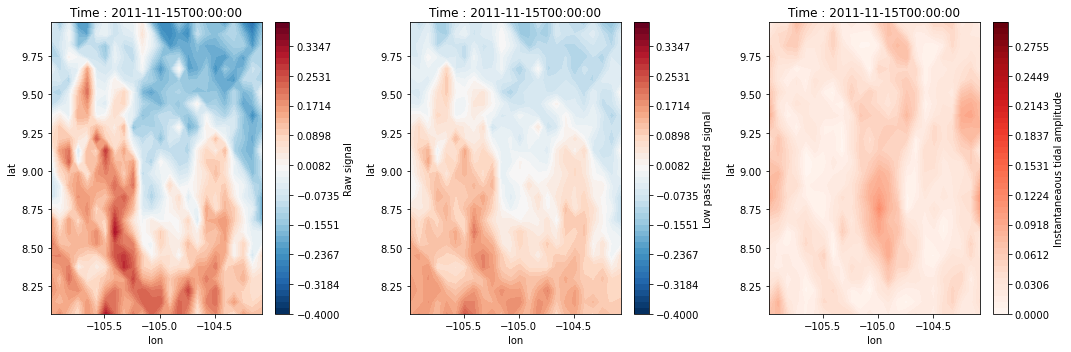

In [10]:
import matplotlib.animation as animation

size = 200#dsi.time.size
fig,ax = plt.subplots(1,3,figsize=(15,5))
cs,cs_low,cs_hf = gen_figs(0)
fig.colorbar(cs,ax=ax[0],label='Raw signal')
fig.colorbar(cs_low,ax=ax[1],label='Low pass filtered signal')
fig.colorbar(cs_hf,ax=ax[2],label='Instantaneaous tidal amplitude')
fig.tight_layout()
ani = animation.FuncAnimation(fig, gen_figs, repeat=False, frames=size,save_count=size)#dsi.time.size
plt.show()

In [11]:
#%timeit
kind = 'mp4'
f = '/Users/zcaspar/Videos/Eulerian_field_eastern_pac.mp4'#+kind
writermp4 = animation.FFMpegWriter(fps=40) 
writergif = animation.PillowWriter(fps=60) 
ani.save(f,writer=writermp4)

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/xarray/plot/plot.py:1426: UserWarning: The following kwargs were not used by contour: 'animated'
  primitive = ax.contourf(x, y, z, **kwargs)

KeyboardInterrupt



In [6]:
def remove_duplicates(df):
    """Find duplicates in dataframe and remove them.
    Create a column 'dt_flag', False if the dt is not different from 1/24
    
    ----------------
    Parameters
    df : dataframe from which duplicates must be removed, dataframe
    
    ----------------
    Returns
    df : input dataframe without duplicates and with new column 'dt_flag', dataframe
    """
#    df = df.reset_index().drop_duplicates('time').sort_values('time')#.set_index('time')
    df = df.drop_duplicates('time').set_index('time')
#    dt_df = df.index[1:]-df.index[:-1]
#    df['dt_flag'] = np.insert(dt_df!=np.timedelta64(1,'h'),0,False)
    return df

In [93]:
_df_sub = dfi.reset_index().groupby('trajectory').apply(remove_duplicates)

In [94]:
_df_sub = dfi.reset_index().set_index('time')#.drop(columns = 'trajectory')
_df_sub

,lon,lat,trajectory,waterdepth,zonal_velocity_demodulated_real,zonal_velocity_demodulated_imag
time,,,,,,
2011-11-15 00:00:00,-100.604164,3.053988,46000147,0.000000,-0.054044,0.029931
2011-11-15 00:00:00,-101.645836,8.802592,46000131,0.000000,-0.036712,0.023670
2011-11-15 00:00:00,-93.312500,9.751602,46000302,0.000000,-0.036301,0.002053
2011-11-15 00:00:00,-111.145836,5.938631,36001634,0.000000,-0.038929,0.035110
2011-11-15 00:00:00,-100.604164,15.371458,46000160,0.000000,0.001440,-0.003880
...,...,...,...,...,...,...
2012-09-30 21:00:00,-97.585855,7.181829,46001522,3440.114990,-0.057632,-0.012883
2012-09-30 21:00:00,-106.217451,10.223432,46000400,3683.949951,-0.015412,0.065940
2012-09-30 21:00:00,-143.014253,14.426952,46001270,4981.120117,-0.030399,0.039330


In [95]:
np.unique(_df_sub.index).size
print(_df_sub.index[0],_df_sub.index[-1])
print(ds.time[0],ds.time[-1])

2011-11-15 00:00:00 2012-09-30 21:00:00
<xarray.DataArray 'time' ()>
array('2011-11-15T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 11
    time     datetime64[ns] 2011-11-15 <xarray.DataArray 'time' ()>
array('2012-09-30T21:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    face     int64 11
    time     datetime64[ns] 2012-09-30T21:00:00


In [84]:
def animate(it,savefig=False,vmax=0.025):
    name=v+'_%s'%it
    fig,ax = plt.subplots(figsize=(5,5))
    cs = (np.abs(dsi[v])**2).isel(time=it).plot.contourf(ax=ax,x='lon',y='lat',vmax=vmax,vmin=0,cmap='OrRd',
                                                        cbar_kwargs={'label':'Instantaneous amplitude (square)'},levels=50)
    _df = _df_sub.loc[time_sub[it]]
    ax.scatter(_df.lon,_df.lat,c='k',s=2)
    ax.set_ylim(latmin,latmax);ax.set_xlim(lonmin,lonmax)
    ax.set_title('Time : %s'%ds.isel(time=it).time.values.astype('M8[s]'))
    fig.tight_layout()
    if savefig:
        fig.savefig('/Users/zcaspar/Videos/Figures_'+area+'flts/'+name+'.jpg')
        plt.close()
    return cs

In [96]:
time_sub = np.unique(_df_sub.index)[::2]

In [97]:
latmin,latmax = dsi.lat.min(),dsi.lat.max()
lonmin,lonmax = dsi.lon.min(),dsi.lon.max()
animate(0,vmax=0.05)

NameError: name 'v' is not defined

In [32]:
v = 'SSU_rot_hat_low'
area = region+'/'
for i in range(dsi.time.size):
    animate(i,savefig=True,vmax=0.05)

In [98]:
flts_bin = _df_sub.where((_df_sub.lat<=latmax.values)&(_df_sub.lat>=latmin.values)
           &(_df_sub.lon<=lonmax.values)&(_df_sub.lon>=lonmin.values)
           )#.groupby('trajectory').count()

In [99]:
traj = np.unique(flts_bin.groupby('trajectory').count().lon.index)

In [100]:
print(flts_bin.groupby('trajectory').count().lon.values.size,traj.size)

167 167


In [101]:
time_bin = np.unique(flts_bin.index.values)

Text(0.5, 0, 'Drifter id')

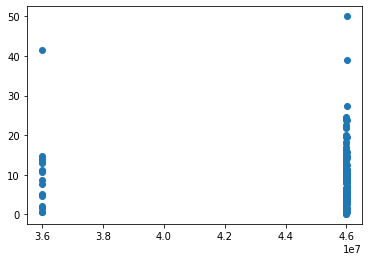

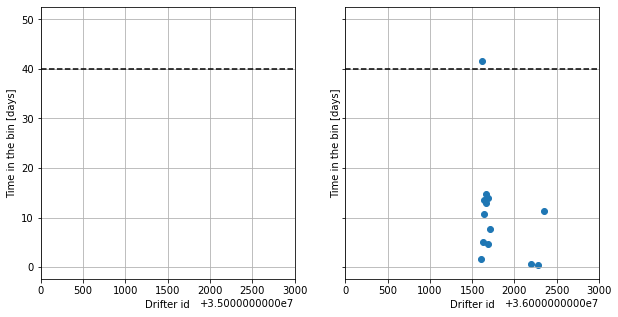

In [102]:
plt.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3)

fig,axs = plt.subplots(1,2,figsize=(10,5),sharey=True)
ax = axs[0]
ax.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3);
ax.set_xlim(3.5e7,3.5003e7)
ax.grid();ax.axhline(40,linestyle='--',c='k');
ax.set_ylabel('Time in the bin [days]');ax.set_xlabel('Drifter id')

ax = axs[1]
ax.scatter(traj,flts_bin.groupby('trajectory').count().lon.values/24*3);
ax.set_xlim(3.6e7,3.6003e7);
ax.grid();ax.axhline(40,linestyle='--',c='k');
ax.set_ylabel('Time in the bin [days]');ax.set_xlabel('Drifter id')

In [ ]:
df_04 = _df_sub.loc['2012-04':'2012-05-10']

In [ ]:
df_04['zonal_velocity_demodulated'] = df_04['zonal_velocity_demodulated_real'
                                           ]+1j*df_04['zonal_velocity_demodulated_imag']

In [65]:
test = df_04.groupby('trajectory').get_group(35000395)

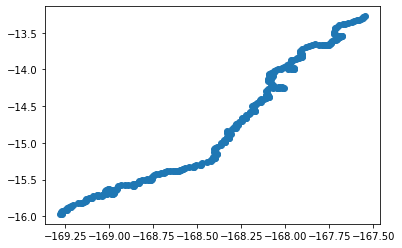

In [66]:
plt.scatter(test.lon,test.lat)

In [81]:
tmid = '2012-04-20 00:00:00'
latmid,lonmid = test.loc[tmid].lat,test.loc[tmid].lon

In [82]:
testE = dsi.sel(lon=lonmid,lat=latmid,method='nearest')

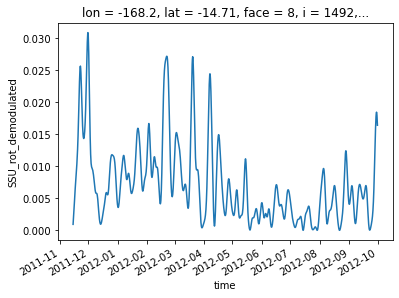

In [84]:
(np.abs(testE.SSU_rot_demodulated)**2).plot()

/opt/anaconda3/envs/croco/lib/python3.8/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


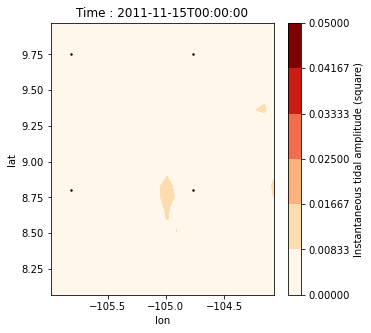

In [89]:
latmin,latmax = ds.lat.min(),ds.lat.max()
lonmin,lonmax = ds.lon.min(),ds.lon.max()
#cbar_kwargs={'label':'Low pass filtered'+v}
fig,ax = plt.subplots(figsize=(5,5))
t0 = animate(0)
fig.colorbar(t0,label='Instantaneous tidal amplitude (square)')
ani = animation.FuncAnimation(fig, animate, frames=20)
plt.show()

In [84]:
ani.save('/Users/zcaspar/Videos/flts_eastern_pac.mp4')